In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('tonawsstkhp.csv')

In [4]:
df.head()

,Unnamed: 0,Payload (Ton),AWSS,TKPH (Ton.Km/Hr)
0,0,153.689871,20.788677,71.884526
1,1,142.843169,19.082928,111.959138
2,2,156.268816,19.829857,80.599379
3,3,171.221396,19.152158,156.645315
4,4,141.205192,11.952323,273.406861


In [7]:
df = df.drop(columns=['Unnamed: 0'])

In [8]:
df.head()

,Payload (Ton),AWSS,TKPH (Ton.Km/Hr)
0,153.689871,20.788677,71.884526
1,142.843169,19.082928,111.959138
2,156.268816,19.829857,80.599379
3,171.221396,19.152158,156.645315
4,141.205192,11.952323,273.406861


In [9]:
tkph_data = df['TKPH (Ton.Km/Hr)'].values.reshape(-1, 1)

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
tkph_scaled = scaler.fit_transform(tkph_data)

In [11]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [12]:
sequence_length = 10
X, y = create_sequences(tkph_scaled, sequence_length)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))




Epoch 1/20

25/25 [==============================] - 20s 196ms/step - loss: 0.0746 - val_loss: 0.0433
Epoch 2/20
25/25 [==============================] - 1s 30ms/step - loss: 0.0540 - val_loss: 0.0430
Epoch 3/20
25/25 [==============================] - 1s 29ms/step - loss: 0.0532 - val_loss: 0.0429
Epoch 4/20
25/25 [==============================] - 1s 29ms/step - loss: 0.0535 - val_loss: 0.0427
Epoch 5/20
25/25 [==============================] - 1s 29ms/step - loss: 0.0532 - val_loss: 0.0422
Epoch 6/20
25/25 [==============================] - 1s 27ms/step - loss: 0.0527 - val_loss: 0.0421
Epoch 7/20
25/25 [==============================] - 1s 43ms/step - loss: 0.0524 - val_loss: 0.0419
Epoch 8/20
25/25 [==============================] - 1s 32ms/step - loss: 0.0523 - val_loss: 0.0417
Epoch 9/20
25/25 [==============================] - 1s 29ms/step - loss: 0.0523 - val_loss: 0.0427
Epoch 10/20
25/25 [==============================] - 1s 29ms/step - loss: 0.0522 - val_loss: 0.0429
Epoc

In [16]:
y_pred = model.predict(X_test)

y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

for i in range(5):
    print(f"Predicted TKPH: {y_pred_rescaled[i][0]:.2f}, Actual TKPH: {y_test_rescaled[i][0]:.2f}")

7/7 [==============================] - 3s 10ms/step
Predicted TKPH: 142.72, Actual TKPH: 175.95
Predicted TKPH: 143.32, Actual TKPH: 149.50
Predicted TKPH: 144.04, Actual TKPH: 244.76
Predicted TKPH: 145.66, Actual TKPH: 73.78
Predicted TKPH: 145.10, Actual TKPH: 82.98


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 6990.6807466345035
Mean Absolute Error: 70.08007083245921


In [18]:
last_sequence = X_test[-1]  
future_predictions = []

for _ in range(10):  # 
    next_pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_predictions.append(next_pred[0][0])
    
    last_sequence = np.append(last_sequence[1:], next_pred[0]).reshape(sequence_length, 1)

future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Future TKPH Predictions:", future_predictions_rescaled.flatten())


1/1 [==============================] - 0s 69ms/step
Future TKPH Predictions: [143.68495 145.25911 145.31139 145.78839 144.66751 143.55482 141.74387
 141.29346 141.10883 141.97322]


7/7 [==============================] - 0s 10ms/step


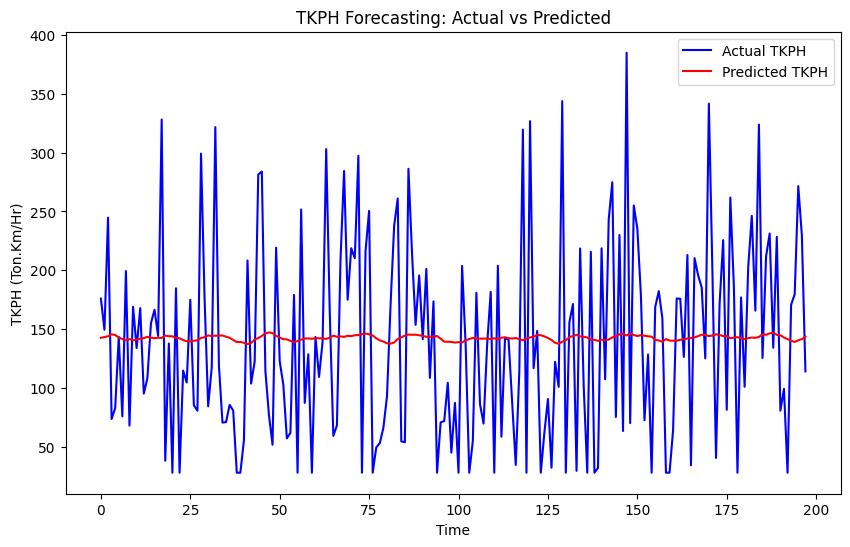

In [19]:
import matplotlib.pyplot as plt

y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Actual TKPH', color='blue')
plt.plot(y_pred, label='Predicted TKPH', color='red')
plt.title('TKPH Forecasting: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('TKPH (Ton.Km/Hr)')
plt.legend()
plt.show()



In [21]:
import numpy as np
import pandas as pd

# Generate synthetic temperature data (assuming temperature varies seasonally in a sine wave pattern)
num_samples = len(df)
days = np.arange(num_samples)

# Simulate temperature as a sine wave (seasonal variation) between 15°C to 35°C
temperature = 25 + 10 * np.sin(2 * np.pi * days / 365)  # 365 is the period (one year)

# Simulate synthetic weather data (categorical, with 0 = Clear, 1 = Rainy, 2 = Snowy)
# Assuming weather is mostly clear, with some rainy and snowy days.
weather = np.random.choice([0, 1, 2], size=num_samples, p=[0.7, 0.2, 0.1])

# Add the synthetic temperature and weather data to the dataframe
df['Temperature (°C)'] = temperature
df['Weather Condition'] = weather

df.to_csv('tkph_with_seasonality.csv', index=False)

In [22]:
df.head()

,Payload (Ton),AWSS,TKPH (Ton.Km/Hr),Temperature (°C),Weather Condition
0,153.689871,20.788677,71.884526,25.000000,1
1,142.843169,19.082928,111.959138,25.172134,0
2,156.268816,19.829857,80.599379,25.344216,0
3,171.221396,19.152158,156.645315,25.516197,1
4,141.205192,11.952323,273.406861,25.688024,0
